<img src=../images/CountyLAVault.png width=1200 margin=0px>

---

# Use Case: Transform Secrets Engine (Enterprise Feature)
---

## Business Value of Capability
* When you need to encrypt data and return ciphertext in a similar format
* When you need to encrypt data and return a masked form of the data

## The Challenge

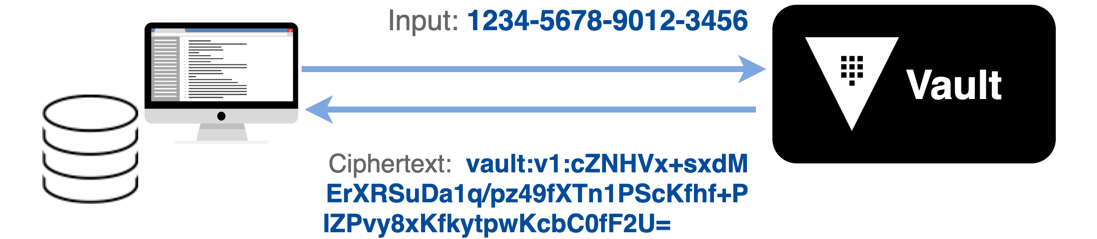

### The Solution Architecture and Result
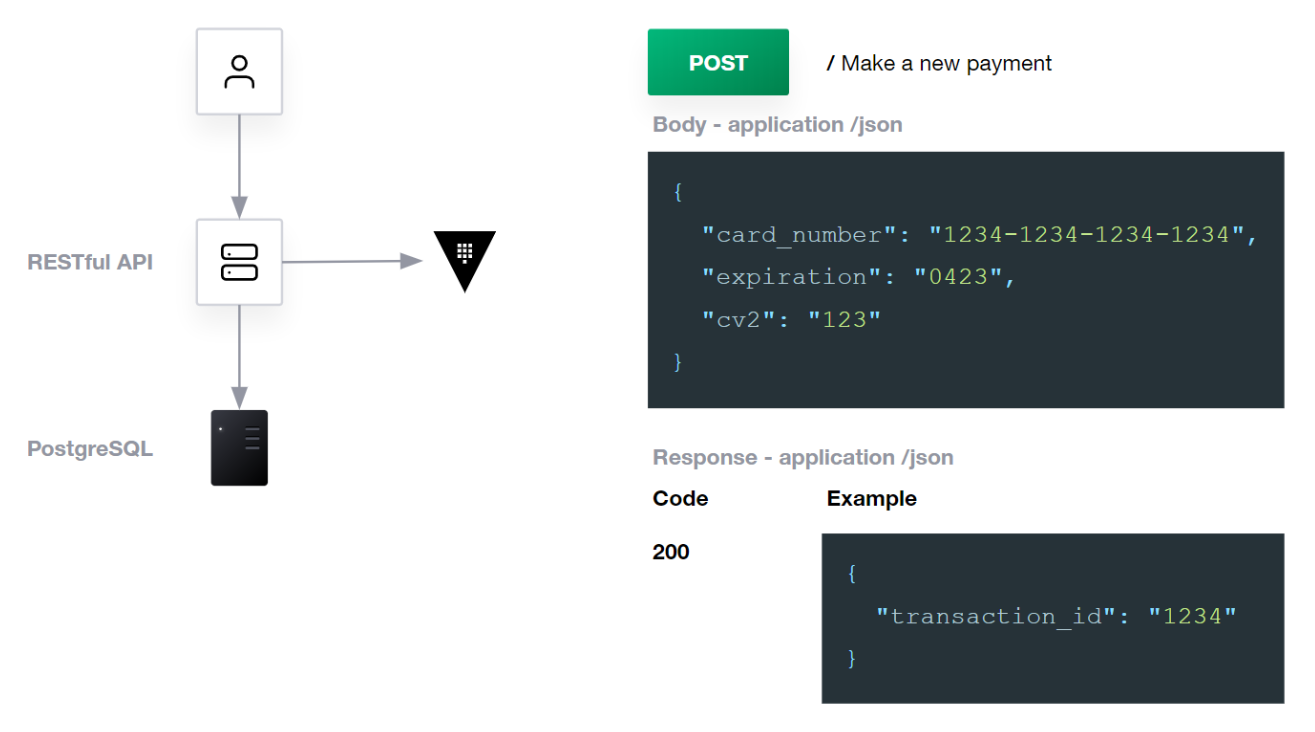

---

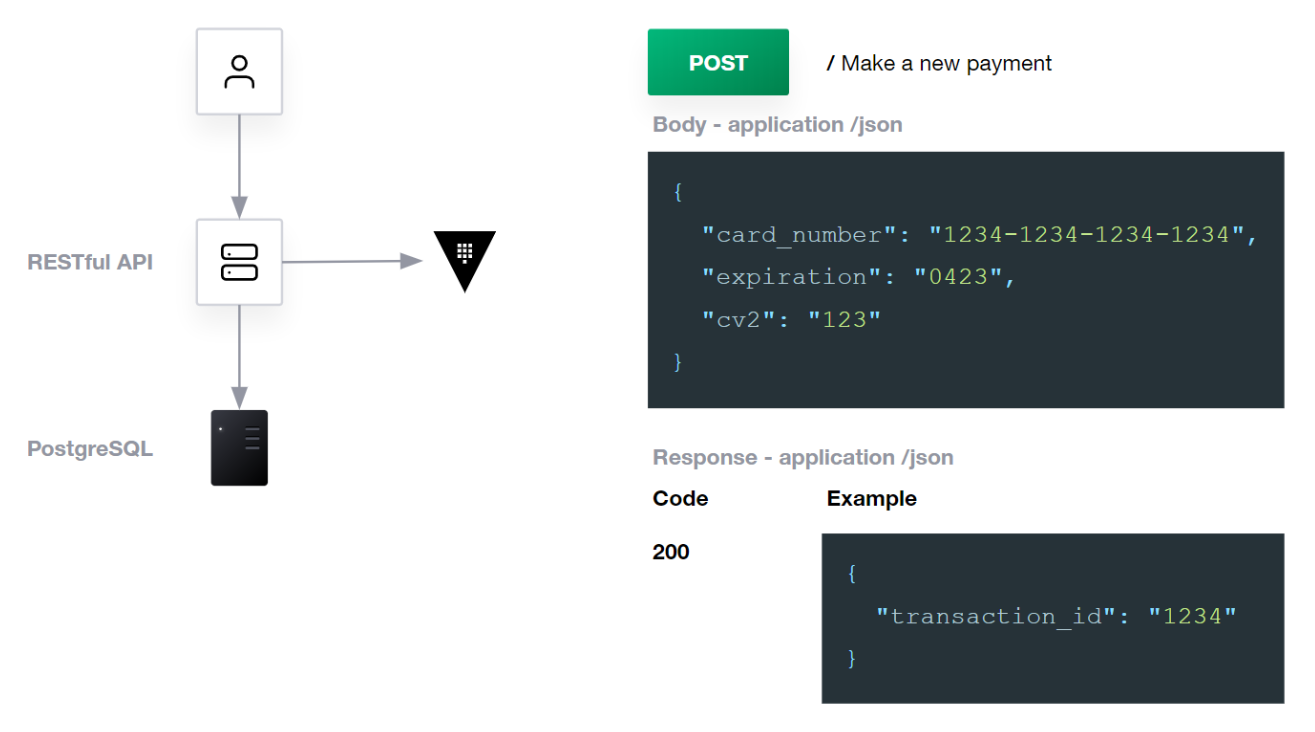

### Setup
---

The basic setup will include

1. Enable the transform secrets engine
2. Create a role containing the transformations that it can perform
3. Create an alphabet defining a set of characters to use for format-preserving encryption (FPE) if not using the built-in alphabets.
4. Create a template defining the rules for value matching if not using the built-in template
5. Create a transformation to specify the nature of the data manipulation

First we ensure we have the correct environment and binaries

In [ ]:
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true
export LICENSE=/Users/jnyika/.licenses/vault.json

In [ ]:
vault login root

In [ ]:
vault status

In [ ]:
vault -version

In [ ]:
#license the server
curl \
  --header "X-Vault-Token: root" \
  --request PUT \
  --data "@${LICENSE}" \
  http://127.0.0.1:8200/v1/sys/license

### Create Policies needed for the engine and client
Write policies to Vault

In [ ]:
cat << EOF > ./config/transforms.hcl
# Work with transform secrets engine
path "transform/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# Enable secrets engine
path "sys/mounts/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# List enabled secrets engine
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}
EOF

In [ ]:
cat << EOF > ./config/transforms-client-policy.hcl
# To request data encoding using any of the roles
# Specify the role name in the path to narrow down the scope
path "transform/encode/*" {
   capabilities = [ "update" , "read", "list"]
}

# To request data decoding using any of the roles
# Specify the role name in the path to narrow down the scope
path "transform/decode/*" {
   capabilities = [ "update" , "read", "list" ]
}
EOF

In [ ]:
vault policy write basictransforms ./config/transforms.hcl

In [ ]:
vault policy write transformsclient ./config/transforms-client-policy.hcl

### Demo
---

### Step 1: Enable Transforms Engine  
(Persona: Operations)

In [ ]:
vault secrets enable transform

### Step 2: Create a 2 roles containing transforms 
(Persona: Operations)
* One role to encrypt standard CC numbers. 
* Another role for a custom operator IDentifier - possibly for a mission

In [ ]:
vault write transform/role/payments transformations=card-number

In [ ]:
vault write transform/role/operators transformations=tfoperatorcode

### Step 3: Create a custom template we shall use for the mission
(Persona: Operations)
 Each operator is assigned a unique code of the form OP-XXX-XXXXXXX-XXX where X is a number

In [ ]:
vault write transform/template/operatorcode \
type=regex \
pattern='OP-(\d{3})-(\d{7})-(\d{3})' \
alphabet="builtin/numeric"

#### Tie the template to a transfromation instruction for a particular role

In [ ]:
vault write transform/transformation/tfoperatorcode \
        type=fpe \
        template="operatorcode" \
        tweak_source=generated \
        allowed_roles=operators

### Step 4: Create the transformation as well for CC numbers
(Persona: Operations)

In [ ]:
vault write transform/transformation/card-number \
        type=fpe \
        template="builtin/creditcardnumber" \
        tweak_source=generated \
        allowed_roles=payments

### Step 5: EXAMPLE: Encode a CC Number

In [ ]:
vault write transform/encode/payments value=1111-2222-3333-4444 

In [ ]:
vault write transform/decode/payments value=8469-0468-2700-6189 tweak=nd7C+dBp2A==

### Step 6: EXAMPLE: Encode an Operator Code

In [ ]:
vault write transform/encode/operators value=OP-556-8473840-644

In [ ]:
vault write transform/decode/operators value=OP-635-4019980-142 tweak=/kO/ELQpAQ==

### Step 7: Modify to use Masking character for operator codes (*)

## **Masking is a unidirectional operation; therefore, encode is the only supported operation.**

In [ ]:
vault write transform/role/operators transformations=tfmaskoperatorcode

In [ ]:
vault write transform/transformation/tfmaskoperatorcode \
        type=masking \
        template="operatorcode" \
        masking_character=▓ \
        allowed_roles=*

In [ ]:
vault write transform/encode/operators value='OP-994-8595836-223'

---

We have demonstrated
1. **Using FPE built ins**
1. **Using Custom templates**
1. **Using Masking**

### Step 8: Tear Down demo

In [ ]:
vault secrets disable transform

**END**